In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import pandas as pd

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [15]:
### Countries' selection
initial = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
timeseries = pd.DataFrame(initial).reset_index()
all_countries = list(set(timeseries.location))
selected_countries = []
for country in all_countries:
    if timeseries.loc[(timeseries.location == country) & (timeseries.variable=='total_deaths')]['value'].max()>300  and 'transit' in set(timeseries.loc[(timeseries.location == country)]['variable']):
        selected_countries.append(country)

In [16]:
set(timeseries.loc[(timeseries.location == 'Italy')]['variable'])

{'driving',
 'grocery_and_pharmacy',
 'new_cases',
 'new_cases_per_million',
 'new_deaths',
 'new_deaths_per_million',
 'new_tests',
 'new_tests_per_thousand',
 'parks',
 'residential',
 'retail_and_recreation',
 'total_cases',
 'total_cases_per_million',
 'total_deaths',
 'total_deaths_per_million',
 'total_tests',
 'total_tests_per_thousand',
 'transit',
 'transit_stations',
 'walking',
 'workplaces'}

In [17]:
selected_countries

['Denmark',
 'Belgium',
 'France',
 'Mexico',
 'Sweden',
 'Switzerland',
 'Spain',
 'United Kingdom',
 'Netherlands',
 'Ireland',
 'Philippines',
 'Germany',
 'Brazil',
 'Japan',
 'Italy',
 'Canada',
 'United States']

In [38]:
def compute_all_datasets(country):   
    ix = pd.IndexSlice

    full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
    populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

    subset = full.loc[country]
    deaths_subset = subset.loc[ix[:, 'total_deaths']]

    pop_country = populations_country.loc[country]

    ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
    begin_date = ten_deaths_date - pd.Timedelta(30, unit='days')

    total_deaths = deaths_subset.loc[begin_date:].rolling('3d').median().rolling('3d').mean().values
    data = total_deaths / pop_country

    times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()


    #Mobility data computation
    mobility = subset.loc[ix[:, 'transit']].rename('mobility')
    mobility = mobility.reindex(deaths_subset.loc[begin_date:].index).fillna(mobility.iloc[-1]).rolling('7d').mean()
    return subset, deaths_subset, pop_country, total_deaths, data, times, mobility

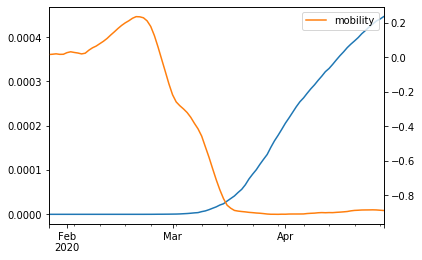

In [7]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = mobility.reindex(deaths_subset.loc[begin_date:].index).fillna(mobility.iloc[-1]).rolling('7d').mean()

to_plot = pd.DataFrame({'deaths': total_deaths / pop_country}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

In [8]:
mobility

date
2020-01-27    0.016000
2020-01-28    0.017750
2020-01-29    0.020133
2020-01-30    0.017100
2020-01-31    0.017540
                ...   
2020-04-24   -0.884271
2020-04-25   -0.883800
2020-04-26   -0.884443
2020-04-27   -0.886043
2020-04-28   -0.887514
Name: mobility, Length: 93, dtype: float64

# SEIR-HCD

## Parameters used in the model

R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

    T_inc = average incubation period. Typical 5.6* days
    T_inf = average infectious period. Typical 2.9 days
    T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
    T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions  
These constants are likely to be age specific (hence the subscript a):

    m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
    c_a = fraction of severe cases that turn critical. Assumed 10%
    f_a = fraction of critical cases that are fatal. Assumed 30%
    
*Averages taken from https://www.kaggle.com/covid-19-contributions

## Model

In [9]:
%%latex
\begin{align}
\frac{dS}{dt} &= - \frac{R_t}{T_{inf}} I S \\
\frac{dE}{dt} &= \frac{R_t}{T_{inf}} I S - \frac{E}{T_{inc}} \\
\frac{dI}{dt} &= \frac{E}{T_{inc}} - \frac{I}{T_{inf}} \\
\frac{dR}{dt} &= m_a \frac{I}{T_{inf}} + (1 - c_a)\frac{H}{T_{hosp}} \\
\frac{dH}{dt} &= (1 - m_a) \frac{I}{T_{inf}} + (1 - f_a)\frac{C}{T_{crit}} - \frac{H}{T_{hosp}} \\
\frac{dC}{dt} &= c_a \frac{H}{T_{hosp}} - \frac{C}{T_{crit}} \\
\frac{dD}{dt} &= f_a \frac{C}{T_{crit}}
\end{align}

<IPython.core.display.Latex object>

In [39]:
def reparametrize_beta(u, v):
#     v = numpyro.sample(f'sample_size_{i}', dist.Exponential(1.))
    return u*v, (1-u)*v

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def run_parameters_inference_by_country(country, counter, NB_EPOCHS):
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]
        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])
    
    def model(N, y=None):
        i_init = numpyro.sample('i_init', dist.TruncatedNormal(loc=50., scale=10.)) / pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        ts = np.arange(float(N))

        kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
        kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
        r0 = numpyro.sample('r0', dist.TruncatedNormal(0, 3.28, kappa0))
        r1 = numpyro.sample('r1', dist.TruncatedNormal(0., 0.7, kappa1))

    #     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
    #     t_delta = int(np.floor(t_delta))

        t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(5.6, .86)))
        t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(2.9, 1.)))
        t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(4., 1.)))
        t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(14., 1.)))

        sample_size = numpyro.sample('sample_size', dist.Exponential(1.0))
        m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, sample_size)))
        c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(0.1, sample_size)))
        f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(0.35, sample_size)))

        params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

        z = seirhcd_int(z_init, ts, *params)

        total_deaths = z[:, -1]
        daily_deaths = np.hstack((np.array([0.]), np.diff(total_deaths * pop_country))) + 1

        psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))

        numpyro.sample('y', dist.GammaPoisson(psi, rate=psi/daily_deaths), obs=y)
        
        return None
        
        
    subset, deaths_subset, pop_country, total_deaths, data, times, mobility = compute_all_datasets(country)
    test_i =1
    
    mobility_data = np.asarray(mobility.to_numpy())
    seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)
    
    data = np.hstack((np.array([0.]), np.diff(total_deaths)))

    # use dense_mass for better mixing rate
    mcmc = MCMC(NUTS(model, dense_mass=True),
                NB_EPOCHS, NB_EPOCHS, num_chains=NUM_CHAINS,
                progress_bar=True)
    mcmc.run(PRNGKey(0), N=data.shape[0], y=data.astype(int))
    print('\n\n\nAnalysis country: {}, number: {}'.format(country, counter))
    mcmc.print_summary()
    
    y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])['y']

    pop_pred = y_pred
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    
    ### First plot
    fig, ax = plt.subplots(figsize=(8, 5))

    plt.plot(times, np.cumsum(data), "bx", label="true")
    plt.plot(times, np.cumsum(mu), "b--", label="pred")
    # plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel('Time', size=12)
    plt.ylabel('Total number of deaths', size=12)

    plt.tight_layout()
    plt.show()
    
    ### Second plot
    fig, ax = plt.subplots(figsize=(8, 5))

    plt.plot(times, data, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.xlabel('Time', size=12)
    plt.ylabel('Daily number of deaths', size=12)

    plt.tight_layout()
    plt.show()
    
    ### Third plot
    inference_data = az.from_numpyro(mcmc)
    az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
    plt.grid()
    az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
    plt.grid()
    az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
    plt.grid()
    plt.show()
    
    return mcmc.get_samples()

def run_inference_all_countries(countries=selected_countries):
    posterior_distributions = {}
    for counter,country in enumerate(countries):
        posterior_distributions[country] = run_parameters_inference_by_country(country, counter, NB_EPOCHS=1000)
    return posterior_distributions

sample: 100%|██████████| 2000/2000 [02:32<00:00, 13.14it/s, 127 steps of size 2.94e-02. acc. prob=0.95] 





Analysis country: Denmark, number: 0

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.07      0.14      0.01      0.00      0.21    536.53      1.00
          f_a      0.38      0.30      0.31      0.00      0.88    713.88      1.00
       i_init     50.80      9.83     51.05     34.78     66.55   1624.79      1.00
       kappa0      0.61      0.36      0.58      0.01      1.11    420.63      1.02
       kappa1      0.92      0.37      0.93      0.37      1.57    572.49      1.01
          m_a      0.83      0.23      0.93      0.45      1.00    717.78      1.00
          psi     12.30      3.06     12.27      7.33     17.17    810.49      1.00
           r0      4.05      0.73      3.90      3.04      5.14    315.95      1.04
           r1      2.36      0.95      2.32      0.72      3.78    562.17      1.00
  sample_size      1.67      0.94      1.45      0.31      2.99    761.96      1.00
       t_crit     13.97      0.99  

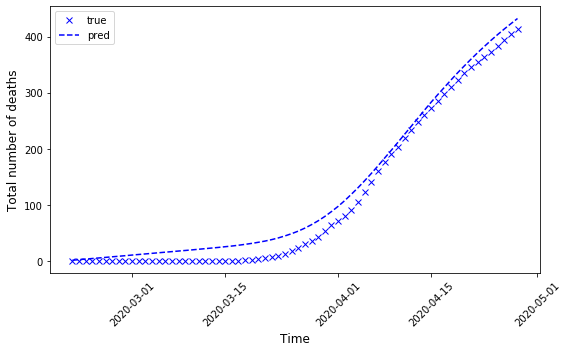

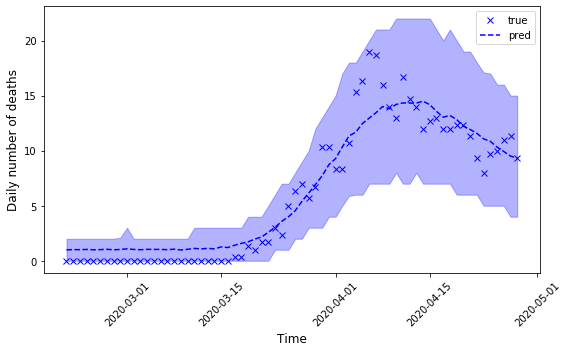

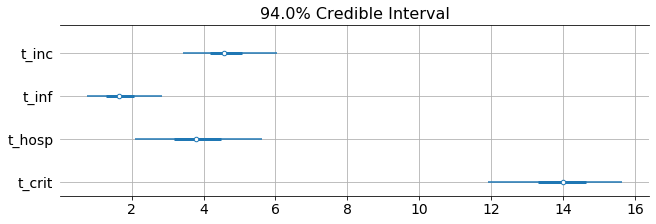

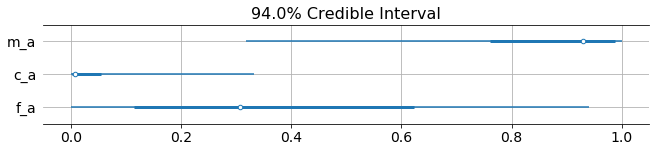

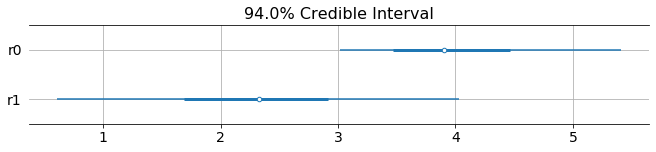

sample: 100%|██████████| 2000/2000 [03:03<00:00, 10.89it/s, 127 steps of size 2.85e-02. acc. prob=0.92]  





Analysis country: Belgium, number: 1

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.13      0.23      0.03      0.00      0.34     40.19      1.02
          f_a      0.42      0.30      0.36      0.00      0.89    127.25      1.01
       i_init     46.35     10.66     46.36     29.75     64.27   1251.24      1.00
       kappa0      0.41      0.30      0.36      0.01      0.86    380.30      1.00
       kappa1      1.25      0.27      1.23      0.84      1.70    972.38      1.00
          m_a      0.78      0.25      0.88      0.40      1.00    944.37      1.00
          psi     14.61      3.19     14.46      9.22     19.24   1022.13      1.00
           r0      3.56      0.39      3.44      3.08      4.22    268.60      1.00
           r1      3.67      0.51      3.61      2.85      4.47    513.59      1.00
  sample_size      1.92      1.16      1.72      0.13      3.62    205.41      1.01
       t_crit     14.00      0.94  

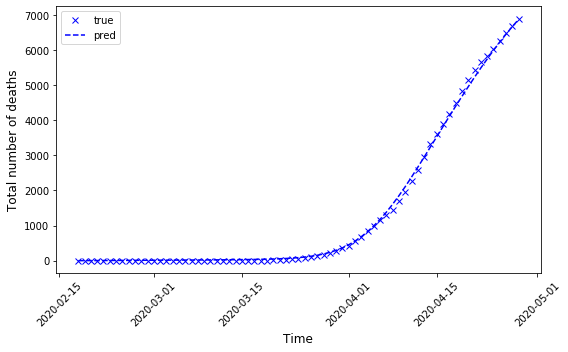

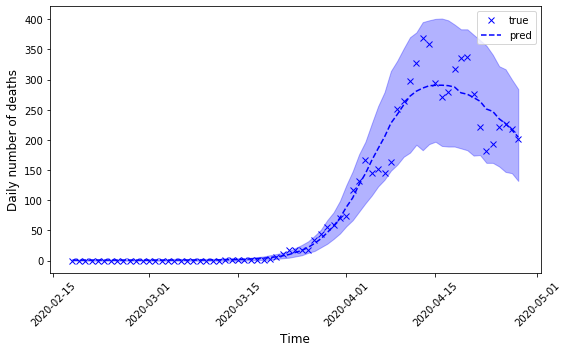

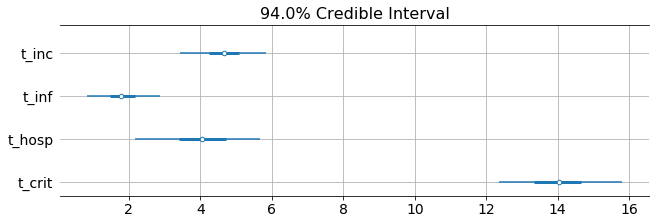

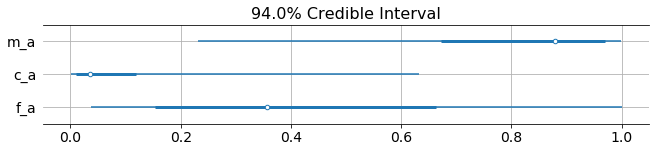

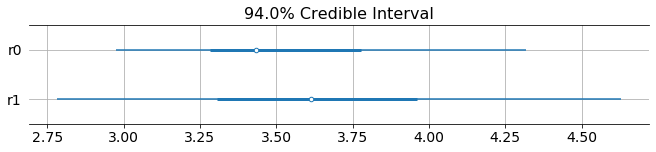

sample: 100%|██████████| 2000/2000 [03:23<00:00,  9.81it/s, 127 steps of size 3.30e-02. acc. prob=0.92] 





Analysis country: France, number: 2

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.05      0.11      0.01      0.00      0.12    409.65      1.00
          f_a      0.44      0.30      0.39      0.00      0.90    422.14      1.00
       i_init     47.99     10.12     47.93     31.48     65.03   1778.22      1.00
       kappa0      0.40      0.29      0.35      0.01      0.81    450.87      1.00
       kappa1      1.14      0.26      1.12      0.74      1.57    922.56      1.00
          m_a      0.78      0.24      0.87      0.39      1.00    675.25      1.00
          psi     13.20      2.53     13.09      9.09     17.33   1135.25      1.00
           r0      3.53      0.36      3.44      3.06      4.13    489.62      1.00
           r1      3.16      0.43      3.11      2.43      3.78    816.81      1.00
  sample_size      1.93      1.16      1.70      0.26      3.56    698.20      1.00
       t_crit     13.63      0.96   

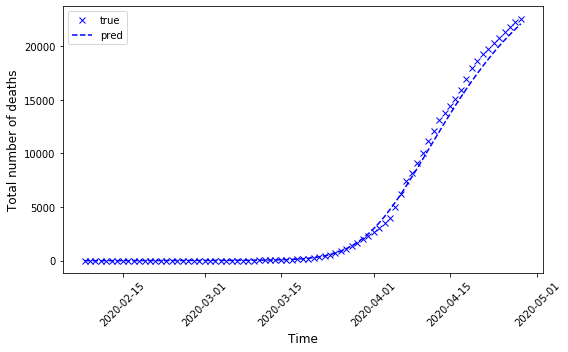

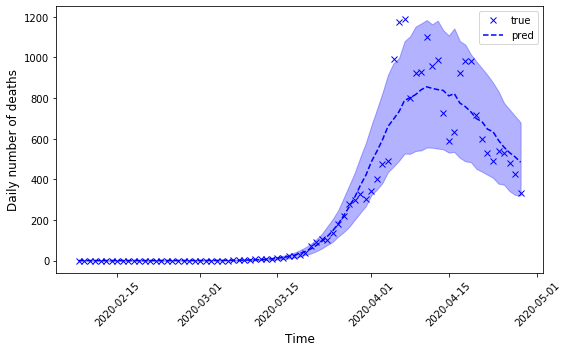

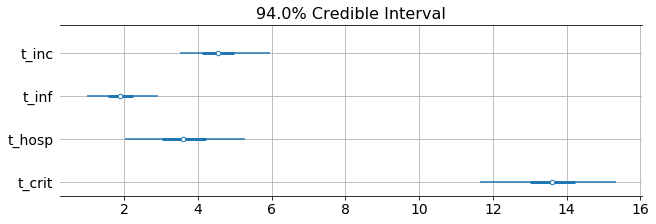

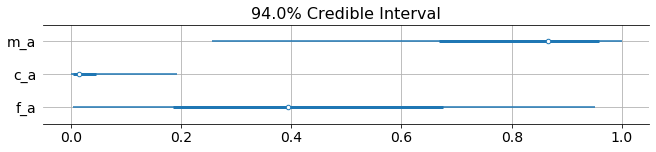

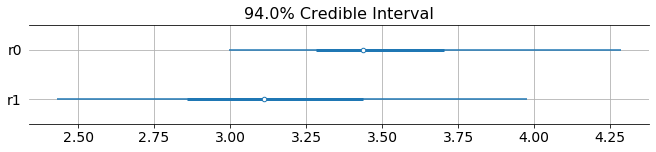

sample: 100%|██████████| 2000/2000 [03:20<00:00,  9.96it/s, 127 steps of size 2.29e-02. acc. prob=0.88]  





Analysis country: Mexico, number: 3

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.11      0.21      0.01      0.00      0.39    536.77      1.00
          f_a      0.32      0.29      0.23      0.00      0.79    681.21      1.00
       i_init     50.01      9.99     49.96     33.92     66.65    910.56      1.00
       kappa0      0.86      0.34      0.86      0.34      1.43    443.72      1.00
       kappa1      0.58      0.30      0.55      0.10      1.04    620.09      1.00
          m_a      0.82      0.24      0.94      0.44      1.00    592.00      1.00
          psi     12.33      3.16     12.19      7.16     17.36    747.13      1.00
           r0      4.81      0.87      4.71      3.46      6.20    344.96      1.00
           r1      1.28      0.37      1.23      0.67      1.79    436.37      1.00
  sample_size      1.72      1.01      1.53      0.22      3.17    476.38      1.00
       t_crit     14.08      0.99   

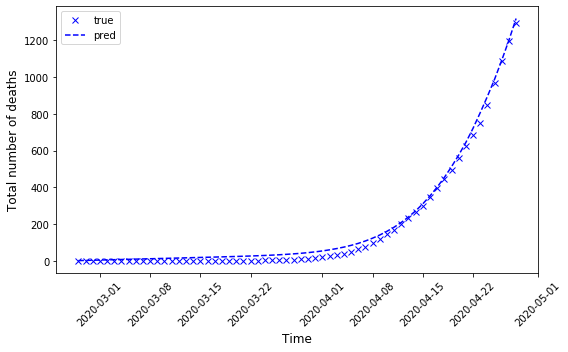

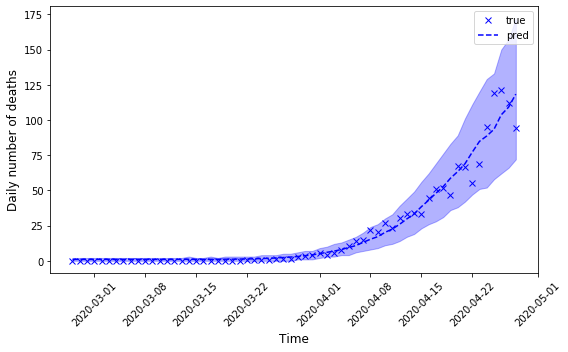

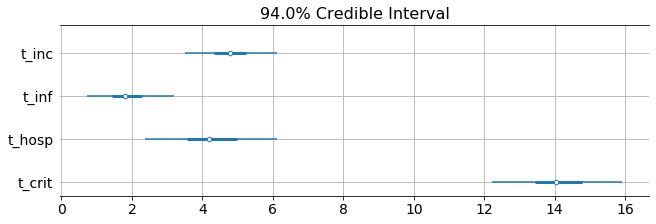

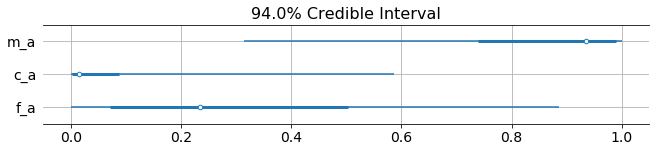

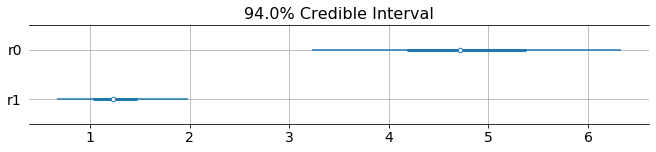

sample: 100%|██████████| 2000/2000 [02:11<00:00, 15.22it/s, 31 steps of size 5.75e-02. acc. prob=0.92]  





Analysis country: Sweden, number: 4

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.12      0.21      0.02      0.00      0.41    341.79      1.00
          f_a      0.40      0.32      0.31      0.00      0.93     80.47      1.01
       i_init     47.91     10.44     47.77     30.77     64.56    844.14      1.00
       kappa0      0.60      0.35      0.56      0.02      1.08    459.84      1.00
       kappa1      0.62      0.37      0.62      0.01      1.11    399.75      1.00
          m_a      0.77      0.28      0.89      0.27      1.00    253.43      1.00
          psi      5.50      1.57      5.33      2.98      7.90    869.96      1.00
           r0      4.01      0.66      3.89      3.15      5.02    381.60      1.00
           r1      1.47      0.80      1.31      0.38      2.72    413.90      1.01
  sample_size      1.75      1.12      1.52      0.25      3.37    273.52      1.00
       t_crit     14.05      0.97   

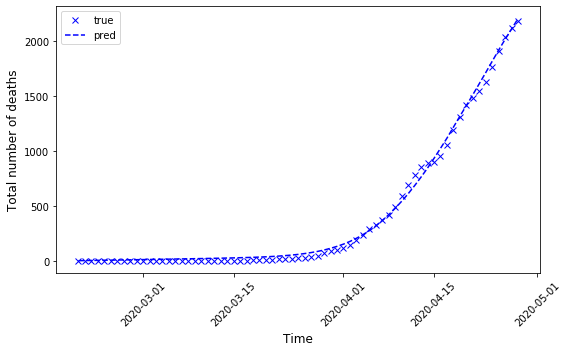

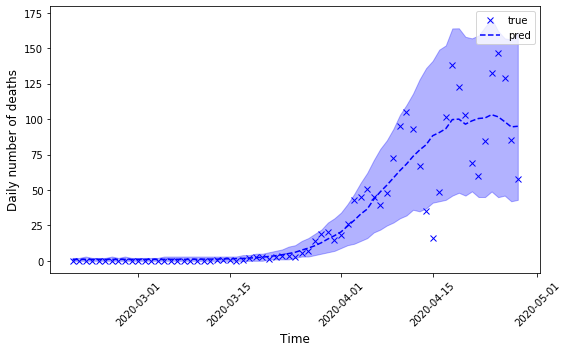

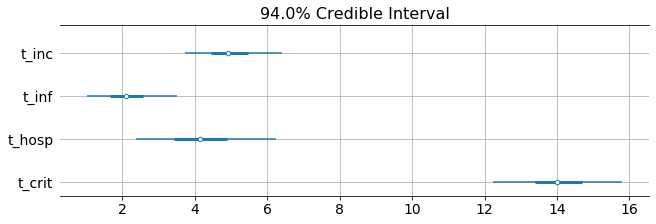

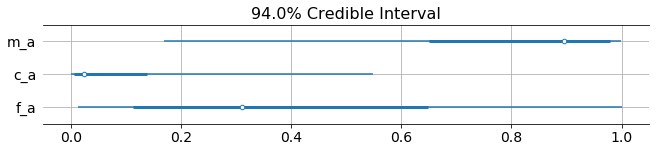

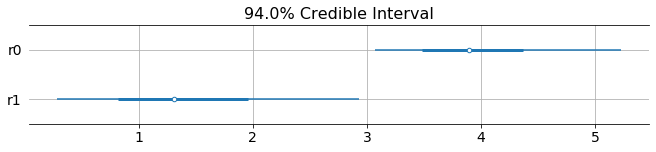

sample: 100%|██████████| 2000/2000 [02:36<00:00, 12.78it/s, 127 steps of size 3.96e-02. acc. prob=0.95] 





Analysis country: Switzerland, number: 5

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.07      0.13      0.01      0.00      0.22    408.92      1.00
          f_a      0.38      0.29      0.31      0.00      0.84    506.73      1.00
       i_init     47.62     10.05     47.88     31.23     63.52    766.64      1.00
       kappa0      0.52      0.33      0.48      0.01      0.97    399.74      1.00
       kappa1      0.92      0.37      0.92      0.30      1.55    469.98      1.00
          m_a      0.79      0.26      0.91      0.36      1.00    178.22      1.00
          psi      9.33      2.52      9.11      5.45     13.49    731.40      1.00
           r0      3.80      0.60      3.62      3.12      4.80    297.52      1.00
           r1      2.44      1.04      2.42      0.64      3.88    436.49      1.00
  sample_size      1.81      1.10      1.60      0.20      3.31    479.95      1.00
       t_crit     14.05      0.

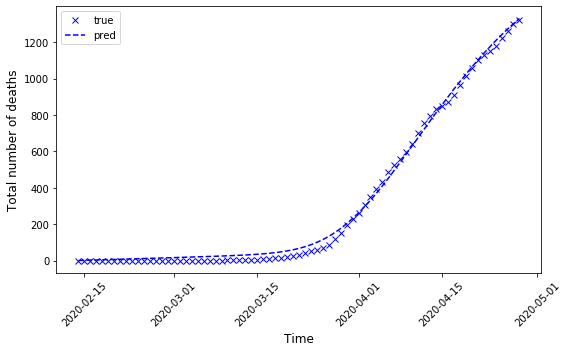

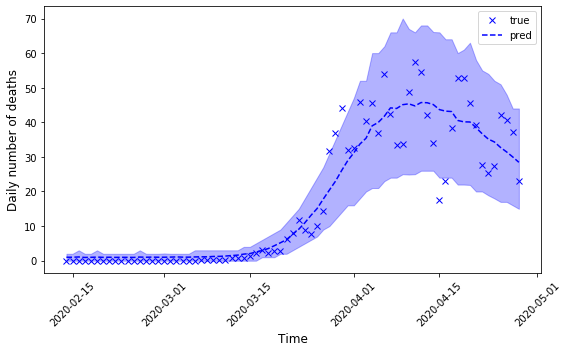

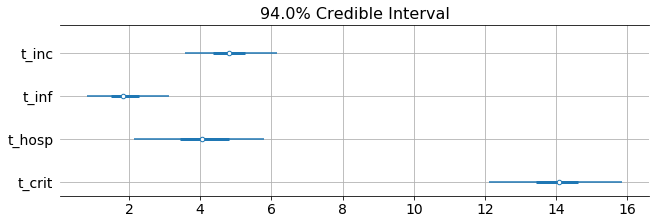

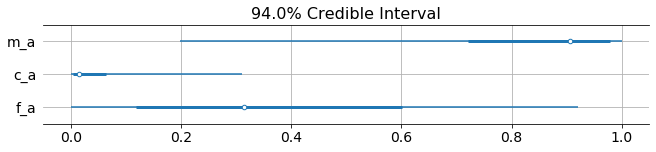

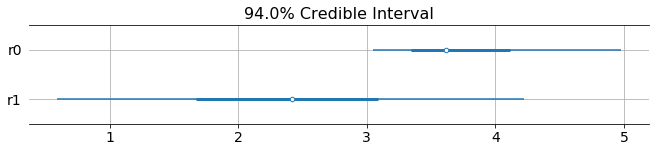

sample: 100%|██████████| 2000/2000 [02:55<00:00, 11.40it/s, 63 steps of size 3.92e-02. acc. prob=0.76]  





Analysis country: Spain, number: 6

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.07      0.11      0.03      0.00      0.13    153.41      1.00
          f_a      0.41      0.28      0.33      0.00      0.90     72.00      1.06
       i_init     32.51     10.48     32.73     12.86     48.09    465.45      1.00
       kappa0      0.47      0.39      0.44      0.01      1.01     16.67      1.09
       kappa1      1.31      0.29      1.30      0.91      1.83     19.41      1.09
          m_a      0.79      0.26      0.91      0.36      1.00    131.11      1.03
          psi     18.74      3.31     18.91     12.89     22.97     37.57      1.05
           r0      3.81      0.56      3.66      3.17      4.63     28.41      1.08
           r1      3.52      0.61      3.42      2.70      4.61    330.78      1.00
  sample_size      1.71      1.24      1.34      0.20      3.43     48.77      1.04
       t_crit     13.81      0.95    

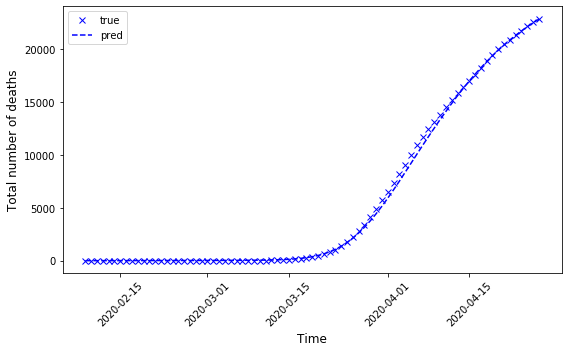

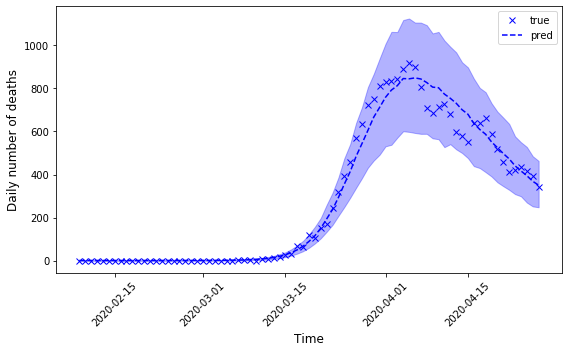

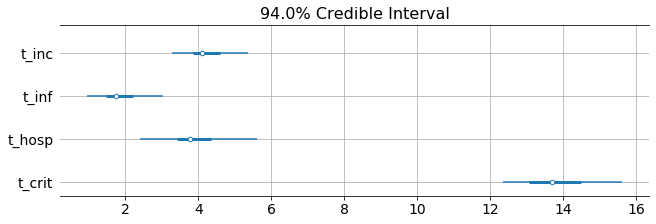

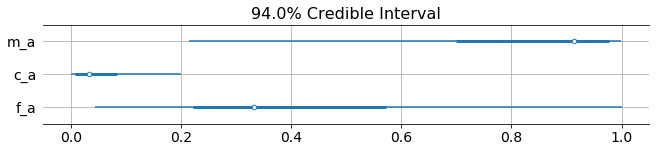

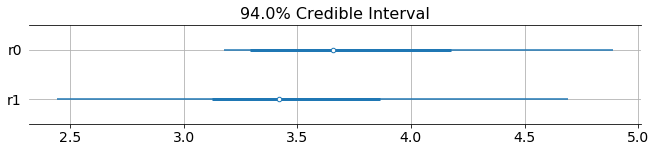

sample: 100%|██████████| 2000/2000 [02:58<00:00, 11.21it/s, 127 steps of size 3.92e-02. acc. prob=0.89] 





Analysis country: United Kingdom, number: 7

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.09      0.17      0.02      0.00      0.26    113.39      1.01
          f_a      0.42      0.31      0.36      0.00      0.91    239.58      1.00
       i_init     47.50     10.13     47.53     30.07     63.11   1175.28      1.00
       kappa0      0.47      0.33      0.43      0.01      0.94    439.06      1.01
       kappa1      1.06      0.26      1.03      0.65      1.46    813.38      1.00
          m_a      0.78      0.25      0.88      0.39      1.00    483.27      1.00
          psi     15.43      3.09     15.53     10.30     20.33    791.58      1.00
           r0      3.71      0.50      3.56      3.02      4.47    330.97      1.00
           r1      2.81      0.38      2.78      2.24      3.42    728.80      1.00
  sample_size      1.88      1.13      1.65      0.35      3.50    419.23      1.00
       t_crit     14.02     

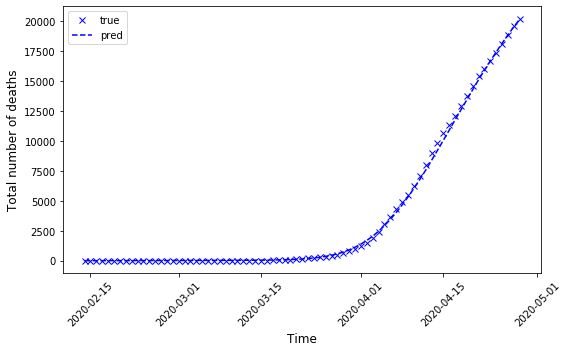

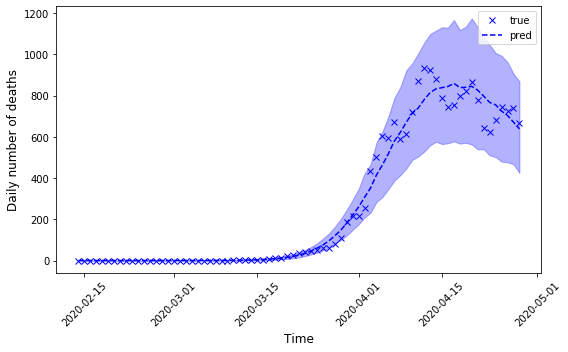

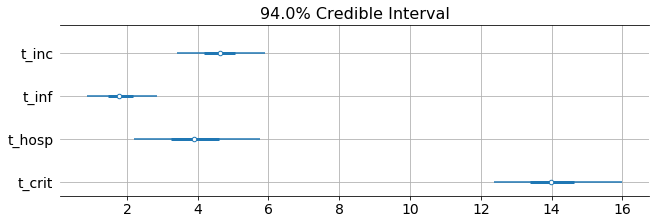

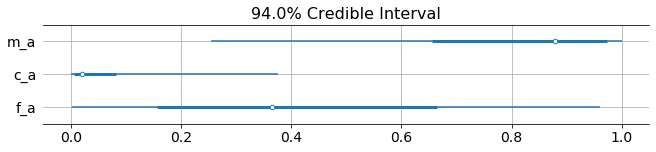

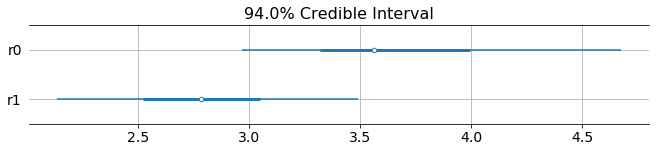

sample: 100%|██████████| 2000/2000 [02:43<00:00, 12.26it/s, 63 steps of size 4.96e-02. acc. prob=0.80]   





Analysis country: Netherlands, number: 8

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.17      0.21      0.06      0.00      0.52    162.32      1.00
          f_a      0.29      0.29      0.20      0.00      0.78     71.67      1.01
       i_init     46.53     10.25     46.03     29.69     62.44    833.03      1.00
       kappa0      0.50      0.33      0.47      0.01      0.94    220.03      1.00
       kappa1      1.13      0.28      1.10      0.71      1.64    439.23      1.00
          m_a      0.75      0.32      0.92      0.10      1.00     24.74      1.06
          psi     14.73      3.14     14.49      9.36     19.30    155.62      1.01
           r0      3.79      0.52      3.68      3.08      4.56    259.25      1.00
           r1      3.20      0.75      3.13      1.91      4.32    442.26      1.00
  sample_size      1.65      1.13      1.40      0.19      3.32     73.02      1.04
       t_crit     14.18      0.

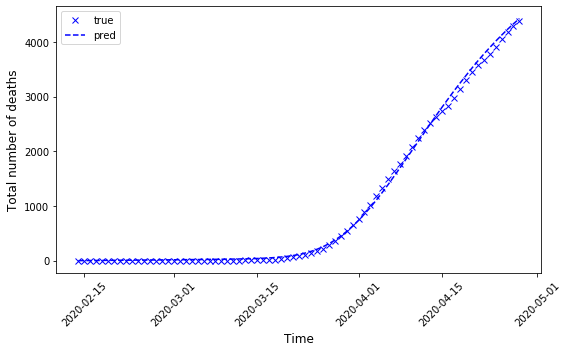

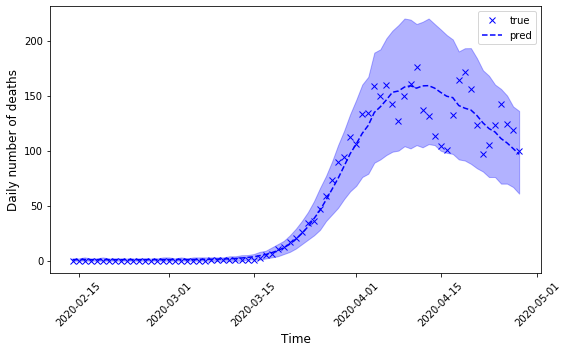

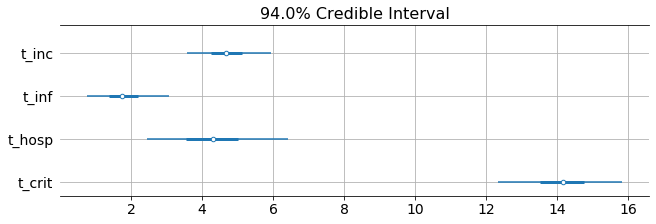

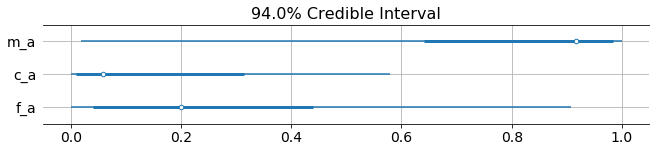

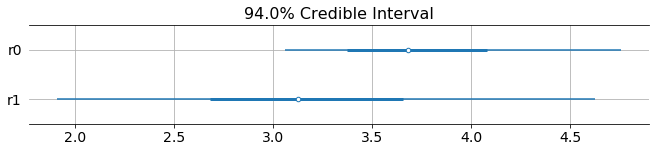

sample: 100%|██████████| 2000/2000 [02:34<00:00, 12.92it/s, 63 steps of size 4.68e-02. acc. prob=0.90]   





Analysis country: Ireland, number: 9

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.19      0.28      0.06      0.00      0.66    168.67      1.01
          f_a      0.36      0.29      0.30      0.00      0.85    452.31      1.00
       i_init     49.27     10.07     49.32     33.47     65.38    935.03      1.00
       kappa0      0.57      0.36      0.53      0.01      1.06    382.19      1.01
       kappa1      0.75      0.28      0.71      0.32      1.17    645.22      1.00
          m_a      0.77      0.26      0.87      0.38      1.00    254.54      1.00
          psi      9.17      2.84      8.93      4.49     13.49    803.46      1.00
           r0      3.96      0.68      3.80      3.14      5.06    332.43      1.01
           r1      1.68      0.34      1.62      1.24      2.18    296.62      1.01
  sample_size      1.87      1.24      1.63      0.13      3.46    369.64      1.00
       t_crit     14.08      0.98  

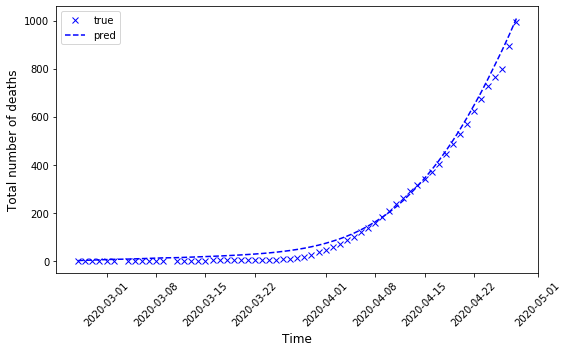

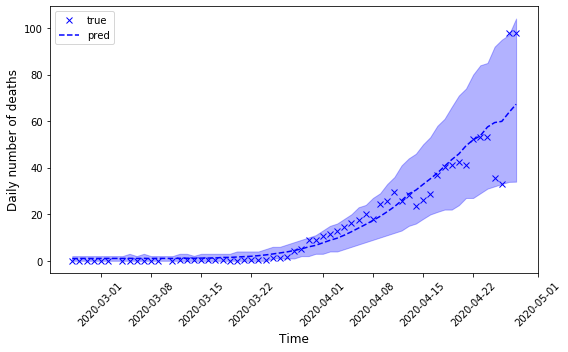

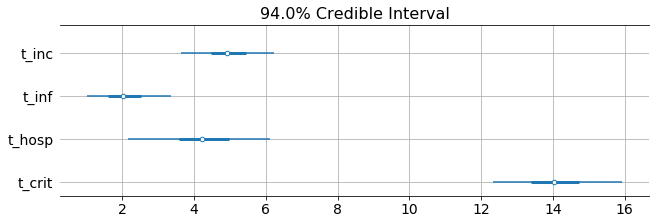

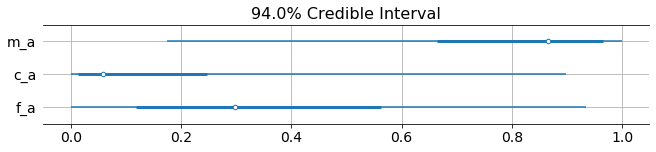

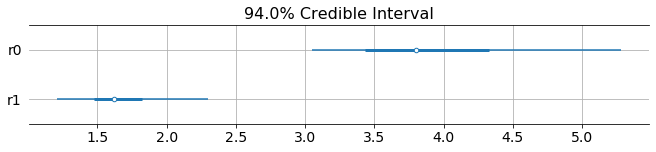

sample: 100%|██████████| 2000/2000 [03:06<00:00, 10.75it/s, 127 steps of size 2.39e-02. acc. prob=0.95]  





Analysis country: Philippines, number: 10

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.06      0.17      0.00      0.00      0.18    233.24      1.01
          f_a      0.38      0.33      0.29      0.00      0.94    404.16      1.00
       i_init     52.86      9.82     52.62     38.02     69.75    804.68      1.00
       kappa0      0.86      0.42      0.89      0.01      1.41    103.68      1.00
       kappa1      0.57      0.37      0.54      0.01      1.07    243.58      1.02
          m_a      0.81      0.28      0.95      0.33      1.00    211.76      1.01
          psi      8.38      2.70      8.17      3.85     12.46    267.54      1.00
           r0      4.95      1.10      4.88      3.20      6.43    120.12      1.00
           r1      1.33      0.73      1.19      0.33      2.34    163.22      1.02
  sample_size      1.44      0.91      1.26      0.14      2.76    260.61      1.00
       t_crit     14.00      1

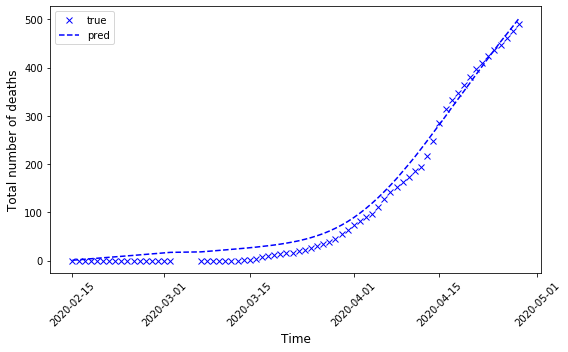

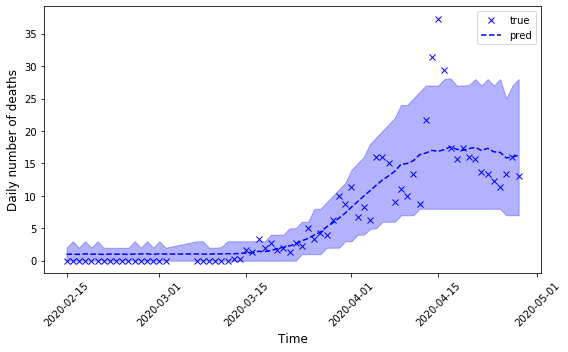

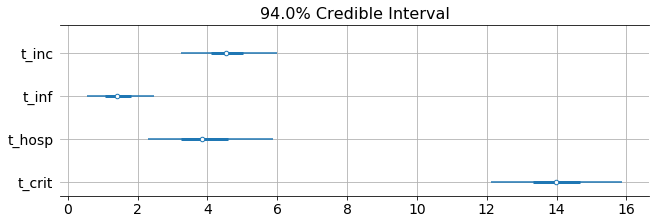

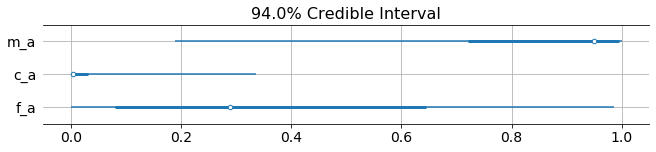

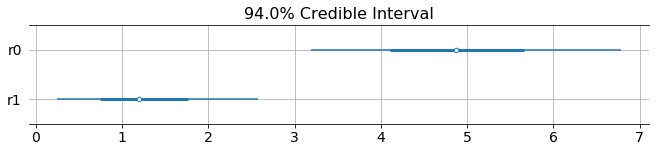

sample: 100%|██████████| 2000/2000 [03:04<00:00, 10.84it/s, 31 steps of size 4.54e-02. acc. prob=0.85]  





Analysis country: Germany, number: 11

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.09      0.18      0.01      0.00      0.32    227.38      1.00
          f_a      0.37      0.31      0.29      0.00      0.88    202.70      1.02
       i_init     47.09      9.86     47.28     30.42     61.75    656.11      1.00
       kappa0      0.53      0.34      0.48      0.03      1.04    318.94      1.00
       kappa1      0.98      0.28      0.95      0.55      1.45    552.01      1.00
          m_a      0.82      0.24      0.92      0.44      1.00    184.36      1.00
          psi     13.19      2.91     12.86      8.61     17.78    721.78      1.00
           r0      3.84      0.57      3.71      3.09      4.67    272.67      1.00
           r1      2.53      0.51      2.48      1.70      3.29    608.80      1.00
  sample_size      1.72      1.02      1.53      0.29      3.15    455.49      1.00
       t_crit     14.10      0.98 

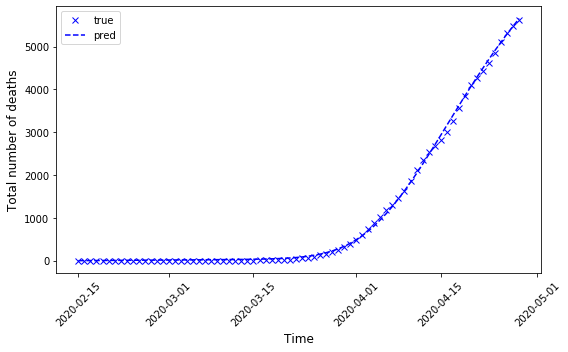

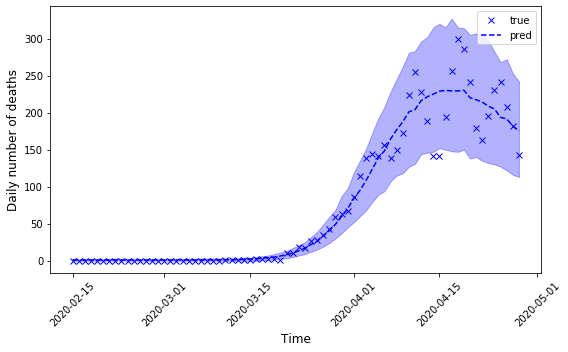

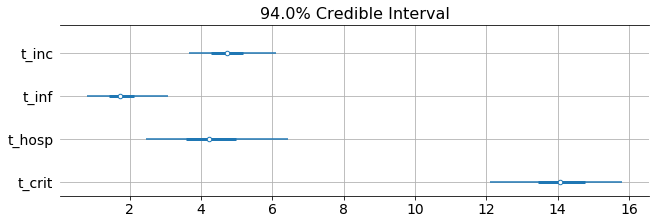

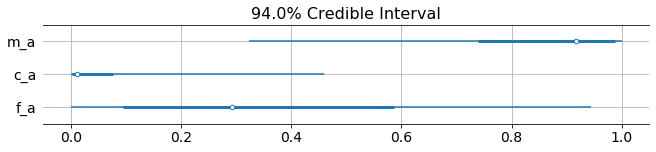

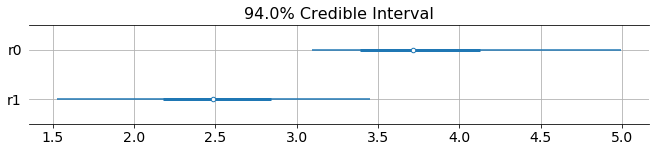

sample: 100%|██████████| 2000/2000 [03:20<00:00,  9.97it/s, 127 steps of size 3.63e-02. acc. prob=0.84] 





Analysis country: Brazil, number: 12

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.14      0.25      0.02      0.00      0.57    245.07      1.01
          f_a      0.31      0.29      0.23      0.00      0.78    427.83      1.00
       i_init     49.05     10.43     49.28     31.85     65.25    659.00      1.00
       kappa0      0.84      0.35      0.83      0.24      1.39    514.96      1.00
       kappa1      0.61      0.28      0.58      0.15      1.05    742.17      1.00
          m_a      0.83      0.24      0.94      0.46      1.00    317.36      1.00
          psi     11.95      2.71     11.79      7.57     16.11    727.80      1.00
           r0      4.70      0.84      4.62      3.23      5.83    339.57      1.00
           r1      1.33      0.27      1.32      0.84      1.75    559.58      1.00
  sample_size      1.69      1.02      1.45      0.35      3.23    573.49      1.00
       t_crit     14.06      0.99  

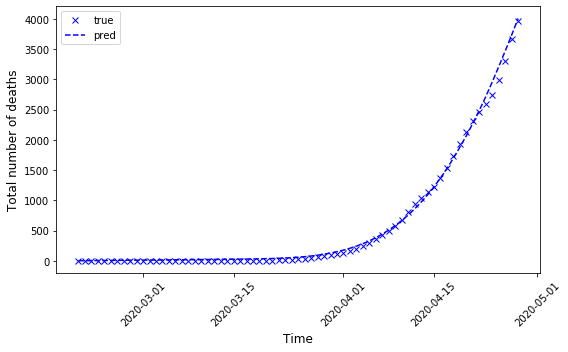

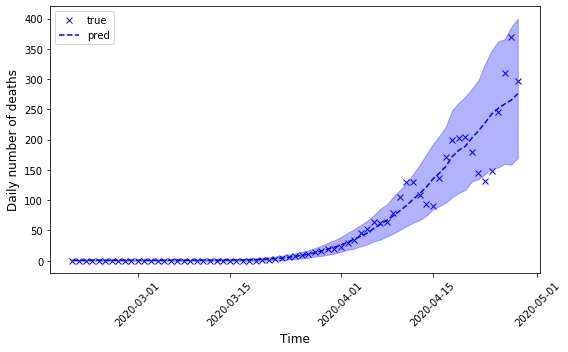

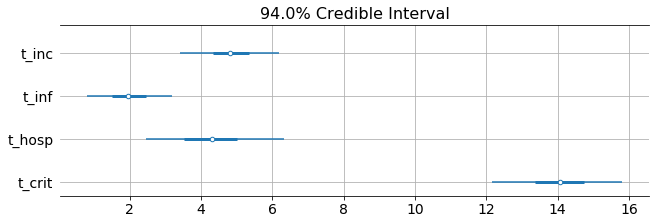

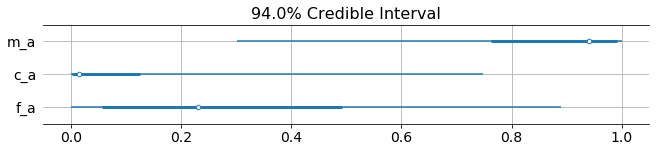

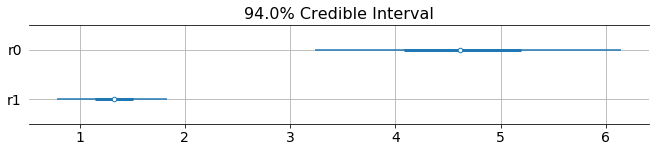

sample: 100%|██████████| 2000/2000 [04:05<00:00,  8.13it/s, 31 steps of size 7.73e-02. acc. prob=0.90]  





Analysis country: Japan, number: 13

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.11      0.22      0.01      0.00      0.41    385.41      1.00
          f_a      0.35      0.32      0.26      0.00      0.90    369.09      1.00
       i_init     48.27     10.19     48.70     30.57     63.51    797.37      1.00
       kappa0      0.38      0.28      0.31      0.02      0.78    789.34      1.00
       kappa1      0.45      0.31      0.39      0.02      0.91    677.86      1.00
          m_a      0.81      0.26      0.94      0.38      1.00    467.86      1.01
          psi      5.00      1.60      4.82      2.53      7.45   1075.32      1.00
           r0      3.17      0.32      3.22      2.60      3.63    717.88      1.00
           r1      0.99      0.53      0.83      0.24      1.82    562.23      1.00
  sample_size      1.62      1.03      1.40      0.19      3.03    451.81      1.00
       t_crit     14.05      0.94   

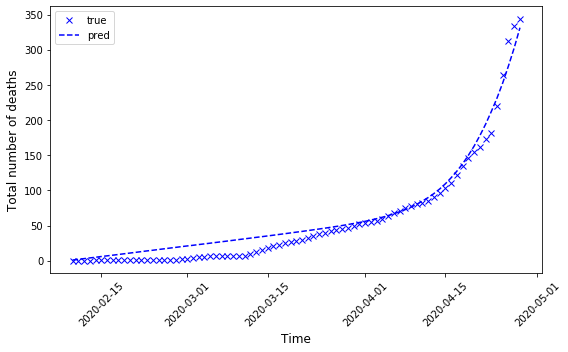

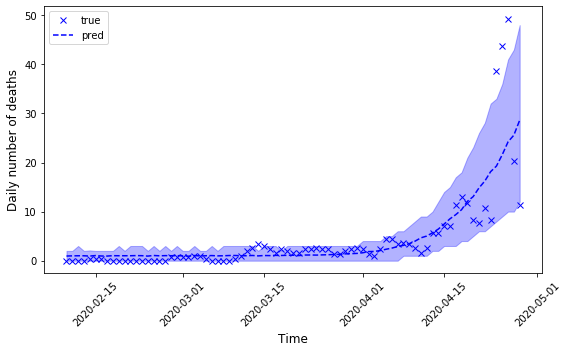

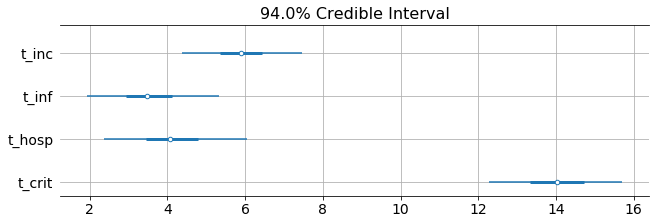

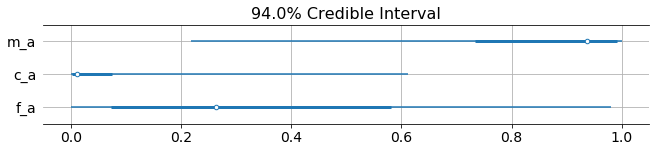

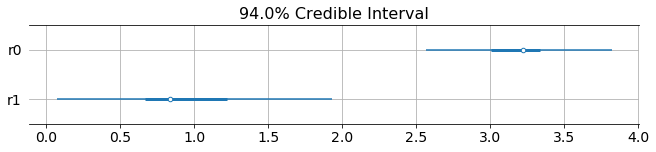

sample: 100%|██████████| 2000/2000 [03:42<00:00,  8.97it/s, 63 steps of size 5.35e-02. acc. prob=0.77]  





Analysis country: Italy, number: 14

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.34      0.21      0.36      0.00      0.62     55.71      1.03
          f_a      0.16      0.17      0.10      0.00      0.39     65.32      1.03
       i_init     36.56     14.24     38.06     11.21     59.65    120.99      1.00
       kappa0      0.57      0.35      0.53      0.01      1.06    179.13      1.00
       kappa1      1.06      0.33      1.05      0.52      1.60    152.00      1.00
          m_a      0.90      0.14      0.97      0.71      1.00     63.01      1.03
          psi     21.06      3.35     20.89     15.72     26.87    362.87      1.00
           r0      3.95      0.65      3.80      3.10      4.94    114.27      1.00
           r1      2.91      0.85      2.96      1.42      4.18    113.10      1.01
  sample_size      1.74      1.04      1.52      0.40      3.26    445.90      1.00
       t_crit     14.31      1.00   

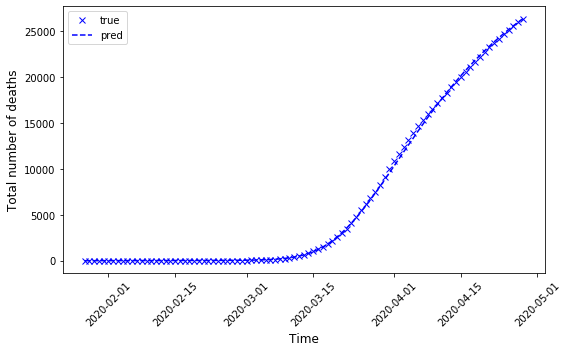

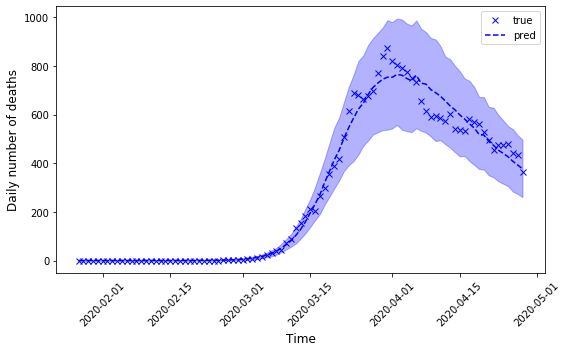

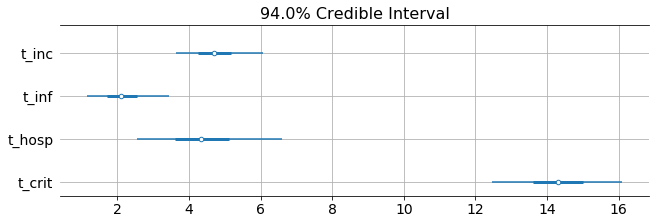

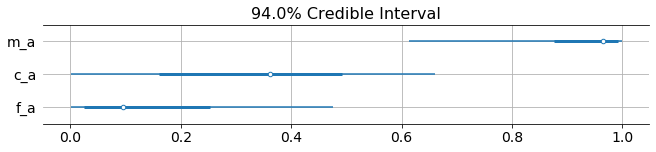

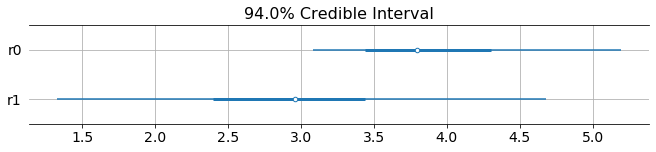

sample: 100%|██████████| 2000/2000 [02:57<00:00, 11.26it/s, 127 steps of size 3.05e-02. acc. prob=0.92] 





Analysis country: Canada, number: 15

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.11      0.21      0.02      0.00      0.42    379.02      1.00
          f_a      0.35      0.30      0.26      0.00      0.82    751.36      1.00
       i_init     50.85     10.28     50.73     34.69     67.48   1029.91      1.00
       kappa0      0.50      0.34      0.45      0.01      0.99    366.76      1.00
       kappa1      0.95      0.26      0.92      0.55      1.41    970.58      1.00
          m_a      0.81      0.25      0.92      0.40      1.00    619.86      1.00
          psi     14.42      3.21     14.22      9.27     19.57   1049.69      1.00
           r0      3.78      0.55      3.65      3.11      4.71    302.77      1.00
           r1      2.39      0.39      2.35      1.82      3.02    611.35      1.00
  sample_size      1.74      1.03      1.55      0.34      3.19    520.11      1.00
       t_crit     14.06      0.97  

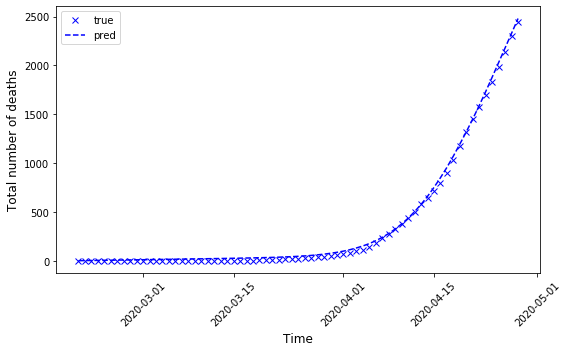

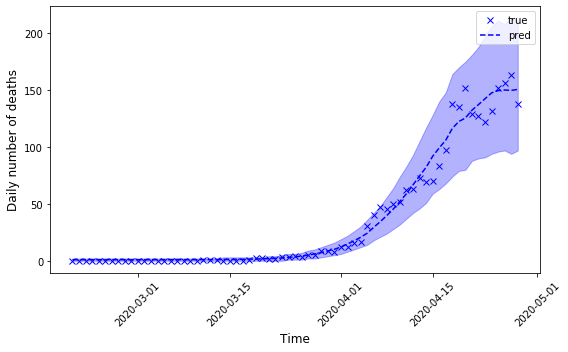

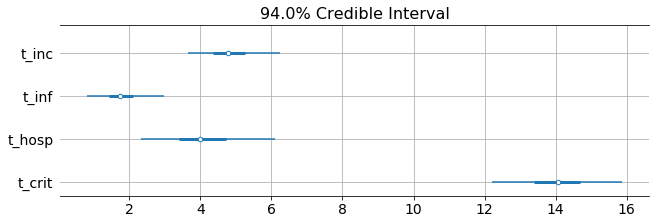

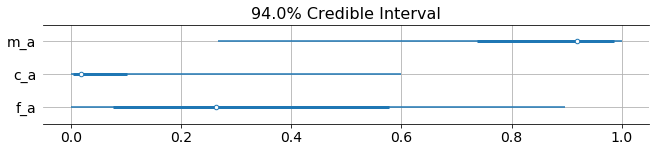

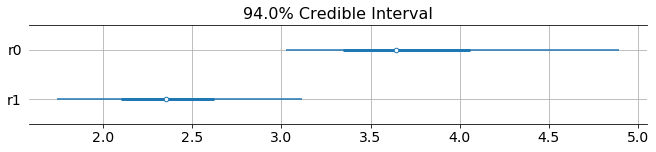

sample: 100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s, 255 steps of size 1.37e-02. acc. prob=0.93] 





Analysis country: United States, number: 16

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.13      0.21      0.03      0.00      0.44    432.32      1.00
          f_a      0.34      0.30      0.25      0.00      0.83    770.43      1.00
       i_init     43.84     10.83     43.85     27.26     61.66    900.08      1.00
       kappa0      0.40      0.29      0.33      0.00      0.79    534.74      1.00
       kappa1      1.24      0.26      1.22      0.78      1.59    967.96      1.00
          m_a      0.81      0.24      0.92      0.46      1.00    810.98      1.00
          psi     15.54      2.84     15.54     10.66     19.71    821.69      1.00
           r0      3.54      0.38      3.42      3.04      4.16    354.66      1.00
           r1      3.60      0.48      3.52      2.86      4.35    791.60      1.00
  sample_size      1.76      1.09      1.53      0.29      3.24    560.01      1.00
       t_crit     14.09     

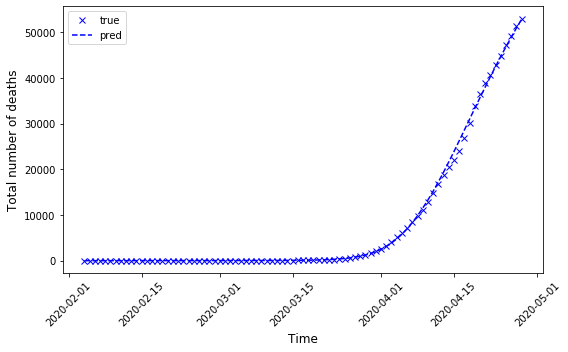

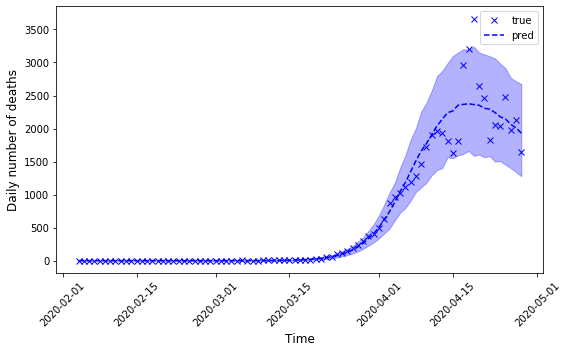

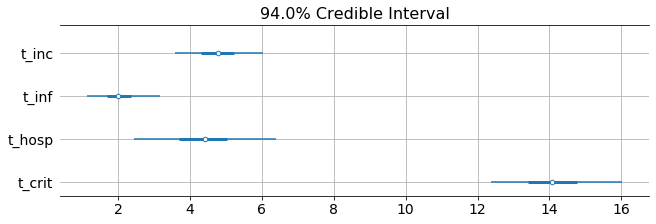

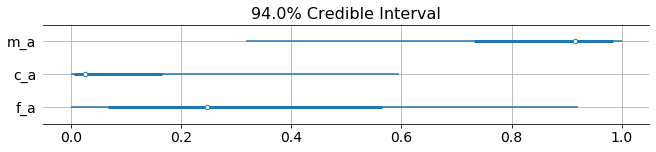

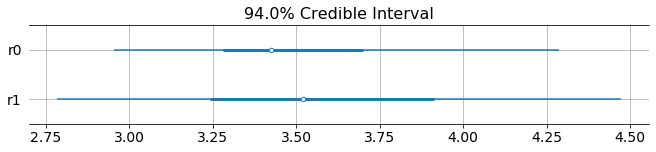

In [40]:
distributions = run_inference_all_countries()

In [24]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [25]:
save_obj(distributions, "distributions")

In [26]:
distributions

{'Denmark': {'c_a': DeviceArray([1.74832795e-03, 8.40765372e-02, 5.46449850e-03,
               1.17603113e-01, 4.94540499e-04, 4.71828410e-04,
               1.41680343e-02, 9.60956518e-03, 1.15569038e-03,
               1.90922161e-03, 4.03898112e-03, 2.37871319e-03,
               2.64311637e-04, 3.06678380e-01, 7.90140353e-02,
               2.16427968e-02, 2.46205432e-02, 1.38437062e-01,
               1.17556538e-01, 2.56760135e-02, 5.69637271e-02,
               4.31991767e-02, 6.11854229e-04, 4.37571045e-03,
               1.56809551e-02, 2.85422970e-02, 2.24712039e-01,
               1.51003991e-01, 1.61858420e-03, 2.30225893e-03,
               4.81222455e-03, 3.12567502e-03, 2.35695339e-02,
               1.67545160e-02, 9.51881609e-04, 3.69877293e-03,
               2.58084564e-02, 2.80988282e-03, 3.44434595e-03,
               2.59584939e-02, 6.62160891e-04, 2.15132132e-03,
               4.03623130e-03, 2.21698750e-04, 7.06945474e-04,
               2.66844051e-03, 5.1022